In [2]:
import os.path
import datetime

import numpy  as np
import pandas as pd

In [3]:
# Variables: dirs and files

dirBase   = '..'

dirData   = os.path.join(dirBase,'Data')
dirPicle  = os.path.join(dirBase,'Data','Pickle')
dirTemp   = os.path.join(dirBase,'Temp','Temp','Class3-1')
dirResult = os.path.join(dirBase,'Result','Leak') 

fileTrain      = os.path.join(dirData,'trainExt.csv')
fileValidation = os.path.join(dirData,'trainExtMin.csv')
fileTest       = os.path.join(dirData,'testExt.csv')

In [4]:
# Constants

chunkSize = 4000000
nClusters = 100
nTop      = 5


In [5]:
# rules field

rule1 = ['user_location_city','orig_destination_distance']
rule2 = ['srch_destination_id','hotel_country','hotel_market']
rule3 = ['srch_destination_id']
rule4 = ['hotel_country']

ruleXtest    = ['cnt','is_booking']
ruleXtrain   = ['hotel_cluster'] + ruleXtest


ruleTrain    = rule1+rule2+ruleXtrain+['dt0y','dty']
ruleTest     = rule1+rule2+ruleXtest+['id']
ruleValidate = ruleTrain

In [6]:
def rule (data,list) :
    df       = data[list].groupby(list).count().reset_index()
    df['nn'] = df.index
    ar       = np.zeros((df.shape[0],nClusters),dtype=np.int16)
    return([df,ar])

In [7]:
# Reader for test data (chunks) on one time if not in disk
print(datetime.datetime.now(),'Read test datas ')
OK =    os.path.exists(os.path.join(dirTemp,'rule1Test0Empty.pkl')) and \
        os.path.exists(os.path.join(dirTemp,'rule2Test0Empty.pkl')) and \
        os.path.exists(os.path.join(dirTemp,'rule3Test0Empty.pkl')) and \
        os.path.exists(os.path.join(dirTemp,'rule4Test0Empty.pkl')) and \
        os.path.exists(os.path.join(dirTemp,'rule1Test1Empty.pkl.npy')) and \
        os.path.exists(os.path.join(dirTemp,'rule2Test1Empty.pkl.npy')) and \
        os.path.exists(os.path.join(dirTemp,'rule3Test1Empty.pkl.npy')) and \
        os.path.exists(os.path.join(dirTemp,'rule4Test1Empty.pkl.npy'))

if not OK :

    readerTest = pd.read_csv(fileTest,chunksize=3000000,usecols=ruleTest);
    i = 0;
    for chunk in readerTest :
        i += 1; print(datetime.datetime.now(),'chunk :',i,chunk.shape)

        rule1Test = rule(chunk,rule1)
        rule2Test = rule(chunk,rule2)
        rule3Test = rule(chunk,rule3)
        rule4Test = rule(chunk,rule4)

    del chunk
    del readerTest
    
    rule1Test[0].to_pickle(os.path.join(dirTemp,'rule1Test0Empty.pkl'))
    rule2Test[0].to_pickle(os.path.join(dirTemp,'rule2Test0Empty.pkl'))
    rule3Test[0].to_pickle(os.path.join(dirTemp,'rule3Test0Empty.pkl'))
    rule4Test[0].to_pickle(os.path.join(dirTemp,'rule4Test0Empty.pkl'))

    np.save(os.path.join(dirTemp,'rule1Test1Empty.pkl.npy'),rule1Test[1])
    np.save(os.path.join(dirTemp,'rule2Test1Empty.pkl.npy'),rule2Test[1])
    np.save(os.path.join(dirTemp,'rule3Test1Empty.pkl.npy'),rule3Test[1])
    np.save(os.path.join(dirTemp,'rule4Test1Empty.pkl.npy'),rule4Test[1])
    
else :
    rule1df = pd.read_pickle(os.path.join(dirTemp,'rule1Test0Empty.pkl'))
    rule2df = pd.read_pickle(os.path.join(dirTemp,'rule2Test0Empty.pkl'))
    rule3df = pd.read_pickle(os.path.join(dirTemp,'rule3Test0Empty.pkl'))
    rule4df = pd.read_pickle(os.path.join(dirTemp,'rule4Test0Empty.pkl'))
    
    rule1ar = np.load(os.path.join(dirTemp,'rule1Test1Empty.pkl.npy'))
    rule2ar = np.load(os.path.join(dirTemp,'rule2Test1Empty.pkl.npy'))
    rule3ar = np.load(os.path.join(dirTemp,'rule3Test1Empty.pkl.npy'))
    rule4ar = np.load(os.path.join(dirTemp,'rule4Test1Empty.pkl.npy'))
    
    rule1Test = [rule1df,rule1ar]
    rule2Test = [rule2df,rule2ar]
    rule3Test = [rule3df,rule3ar]
    rule4Test = [rule4df,rule4ar]
    del rule1df,rule2df,rule3df,rule4df
    del rule1ar,rule2ar,rule3ar,rule4ar
    
    print(rule1Test[1].shape,rule2Test[1].shape,rule3Test[1].shape,rule4Test[1].shape)

print(datetime.datetime.now(),'Done ')    

2016-06-04 06:51:30.082079 Read test datas 
(1385522, 100) (43831, 100) (40718, 100) (206, 100)
2016-06-04 06:51:36.879017 Done 


In [9]:
iGroup = 0
def ruleApply (group,Arr) :
    global iGroup
    nn = group['nn'].iloc[0]; 
    if (iGroup%50000==0) : 
        print(datetime.datetime.now(),'iGroup =',iGroup,'nn =',nn, 'len(group) = ',group.shape)
    iGroup  += 1
    gr  = group[['hotel_cluster','cnt']].groupby(['hotel_cluster']).sum().reset_index()
    Arr[nn][gr['hotel_cluster']] += gr['cnt']
    return True

In [10]:
def findTop (a) :
    b = pd.Series(a); b=np.array(b[b>0].nlargest(nTop).index); 
    b=b+1; b.resize(nTop); b=b-1 
    return(b)

In [11]:
# Reader for train data (chunks) if not in files

# ------------------------------------------------------------------------------

print(datetime.datetime.now(),'Read test datas from pickle')

rule1df = pd.read_pickle(os.path.join(dirTemp,'rule1Test0Empty.pkl'))
rule2df = pd.read_pickle(os.path.join(dirTemp,'rule2Test0Empty.pkl'))
rule3df = pd.read_pickle(os.path.join(dirTemp,'rule3Test0Empty.pkl'))
rule4df = pd.read_pickle(os.path.join(dirTemp,'rule4Test0Empty.pkl'))

rule1ar = np.load(os.path.join(dirTemp,'rule1Test1Empty.pkl.npy'))
rule2ar = np.load(os.path.join(dirTemp,'rule2Test1Empty.pkl.npy'))
rule3ar = np.load(os.path.join(dirTemp,'rule3Test1Empty.pkl.npy'))
rule4ar = np.load(os.path.join(dirTemp,'rule4Test1Empty.pkl.npy'))

rule1Test = [rule1df,rule1ar]
rule2Test = [rule2df,rule2ar]
rule3Test = [rule3df,rule3ar]
rule4Test = [rule4df,rule4ar]
del rule1df,rule2df,rule3df,rule4df
del rule1ar,rule2ar,rule3ar,rule4ar
# ------------------------------------------------------------------------------    
print(datetime.datetime.now(),'Read&Work train datas ')
chunkSize = 10000000
#chunkSize = 2000000
#chunkSize = 60000

OK =    os.path.exists(os.path.join(dirTemp,'rule1Test1.pkl.npy')) and \
        os.path.exists(os.path.join(dirTemp,'rule2Test1.pkl.npy')) and \
        os.path.exists(os.path.join(dirTemp,'rule3Test1.pkl.npy')) and \
        os.path.exists(os.path.join(dirTemp,'rule4Test1.pkl.npy'))

if not OK :        
    readerTrain = pd.read_csv(fileTrain,chunksize=chunkSize,usecols=ruleTrain);
    readerTrain

    ichunk = -1;
    for chunk in readerTrain :
        ichunk += 1; 
        #if (i>1) : print(datetime.datetime.now(),'break :',i); break;
        print(datetime.datetime.now(),'chunk :',ichunk,chunk.shape)
        
        #
        # app1 = 3+is_booking*17
        # app2 = 1+is_booking*5
        #
        
        # Rule1 --> user_location_city+orig_destination_distance += 1
        print(datetime.datetime.now(),'1'); iGroup = 0;
        grp = chunk[rule1+ruleXtrain].groupby(rule1+['hotel_cluster']).sum().reset_index()
        grp.loc[:,'cnt'] = 1 # grp.cnt*(3+17*grp.is_booking)
        print(datetime.datetime.now(),'grp=(train group)',grp.shape)
        print(datetime.datetime.now(),'grpx=(test group)',rule1Test[0].shape)
        grp = grp.merge(rule1Test[0],how='inner',on=rule1,copy=False).groupby(rule1)
        print(datetime.datetime.now(),'grp=(new groups)',len(grp));
        grp.apply(ruleApply,rule1Test[1])
        #ruleWork(grp,rule1Test)
        

        # Rule2 --> (year==2014) : srch_destination_id+hotel_country+hotel_market += app1
        print(datetime.datetime.now(),'2'); iGroup = 0;
        grp = chunk.query('dty==2014')[rule2+ruleXtrain];
        grp.loc[:,'cnt'] = (3+17*grp.is_booking) #*grp.cnt
        grp = grp.groupby(rule2+['hotel_cluster']).sum().reset_index()
        print(datetime.datetime.now(),'grp=(train group)',grp.shape)
        print(datetime.datetime.now(),'grpx=(test group)',rule2Test[0].shape)
        grp = grp.merge(rule2Test[0],how='inner',on=rule2,copy=False).groupby(rule2)
        print(datetime.datetime.now(),'grp=(new groups)',len(grp));
        grp.apply(ruleApply,rule2Test[1])
        #ruleWork(grp,rule2Test,b0Add=3,b1Add=20)
        
        # Rule3 --> srch_destination_id += app1
        print(datetime.datetime.now(),'3'); iGroup = 0;
        grp = chunk[rule3+ruleXtrain]
        #grp.loc[:,'cnt'] = grp.cnt*(3+17*grp.is_booking)
        grp.loc[:,'cnt'] = (3+17*grp.is_booking) #*grp.cnt
        grp = grp.groupby(rule3+['hotel_cluster']).sum().reset_index()
        print(datetime.datetime.now(),'grp=(train group)',grp.shape)
        print(datetime.datetime.now(),'grpx=(test group)',rule3Test[0].shape)
        grp = grp.merge(rule3Test[0],how='inner',on=rule3).groupby(rule3)
        print(datetime.datetime.now(),'grp=(new groups)',len(grp))
        grp.apply(ruleApply,rule3Test[1])
        
        # Rule4 --> hotel_country += app2
        print(datetime.datetime.now(),'4'); iGroup = 0;
        grp = chunk[rule4+ruleXtrain]
        grp.loc[:,'cnt'] = (1+5*grp.is_booking) # *grp.cnt
        grp = grp.groupby(rule4+['hotel_cluster']).sum().reset_index()
        print(datetime.datetime.now(),'grp=(train group)',grp.shape)
        print(datetime.datetime.now(),'grpx=(test group)',rule4Test[0].shape)
        grp = grp.merge(rule4Test[0],how='inner',on=rule4).groupby(rule4)
        print(datetime.datetime.now(),'grp=(new groups)',len(grp))
        grp.apply(ruleApply,rule4Test[1])
        
    del readerTrain
    np.save(os.path.join(dirTemp,'rule1Test1.pkl.npy'),rule1Test[1])
    np.save(os.path.join(dirTemp,'rule2Test1.pkl.npy'),rule2Test[1])
    np.save(os.path.join(dirTemp,'rule3Test1.pkl.npy'),rule3Test[1])
    np.save(os.path.join(dirTemp,'rule4Test1.pkl.npy'),rule4Test[1])
    
    print(datetime.datetime.now(),'Build array5 begin')
    rule1Arr5 = np.apply_along_axis(findTop,1,rule1Test[1]); print(rule1Arr5.shape)
    rule2Arr5 = np.apply_along_axis(findTop,1,rule2Test[1]); print(rule2Arr5.shape)
    rule3Arr5 = np.apply_along_axis(findTop,1,rule3Test[1]); print(rule3Arr5.shape)
    rule4Arr5 = np.apply_along_axis(findTop,1,rule4Test[1]); print(rule4Arr5.shape)

    np.save(os.path.join(dirTemp,'rule1Test2.pkl.npy'),rule1Arr5)
    np.save(os.path.join(dirTemp,'rule2Test2.pkl.npy'),rule2Arr5)
    np.save(os.path.join(dirTemp,'rule3Test2.pkl.npy'),rule3Arr5)
    np.save(os.path.join(dirTemp,'rule4Test2.pkl.npy'),rule4Arr5)

    print(datetime.datetime.now(),'Build array5 end')
    
else :  
    rule1ar = np.load(os.path.join(dirTemp,'rule1Test1.pkl.npy'))
    rule2ar = np.load(os.path.join(dirTemp,'rule2Test1.pkl.npy'))
    rule3ar = np.load(os.path.join(dirTemp,'rule3Test1.pkl.npy'))
    rule4ar = np.load(os.path.join(dirTemp,'rule4Test1.pkl.npy'))
    
    rule1Test[1] = rule1ar
    rule2Test[1] = rule2ar
    rule3Test[1] = rule3ar
    rule4Test[1] = rule4ar
    del rule1ar,rule2ar,rule3ar,rule4ar
    
    print(rule1Test[1].shape,rule2Test[1].shape,rule3Test[1].shape,rule4Test[1].shape)
    
    rule1Arr5 = np.load(os.path.join(dirTemp,'rule1Test2.pkl.npy'))
    rule2Arr5 = np.load(os.path.join(dirTemp,'rule2Test2.pkl.npy'))
    rule3Arr5 = np.load(os.path.join(dirTemp,'rule3Test2.pkl.npy'))
    rule4Arr5 = np.load(os.path.join(dirTemp,'rule4Test2.pkl.npy'))
        
print(datetime.datetime.now(),'Done ')

2016-06-04 06:52:06.836350 Read test datas from pickle
2016-06-04 06:52:07.122615 Read&Work train datas 
(1385522, 100) (43831, 100) (40718, 100) (206, 100)
2016-06-04 06:52:14.628763 Done 


In [25]:
# Calculate user_id stats
if True :
    
    print(datetime.datetime.now(),'User stats ')

    chunkSize = 10000000
    readerTrain = pd.read_csv(fileTrain,chunksize=chunkSize,usecols=['user_id','is_booking','cnt','dt0y','dt0m']);
    readerTrain
    
    grps   = pd.DataFrame()

    ichunk = -1;
    for chunk in readerTrain :
        ichunk += 1; 
        #if (ichunk>1) : print(datetime.datetime.now(),'break :',ichunk); break;
        print(datetime.datetime.now(),'chunk :',ichunk,chunk.shape)
        
        #
        # app1 = 3+is_booking*17
        # app2 = 1+is_booking*5
        #
        
        # Rule1 --> user_location_city+orig_destination_distance += 1
        print(datetime.datetime.now(),'1'); iGroup = 0;
        grp = chunk[['user_id','is_booking','cnt']].groupby('user_id').sum().reset_index()
        
        grps = grps.append(grp)
        
    grps = grps.groupby('user_id').sum().reset_index()
    print(grps.shape)    
    
    print(datetime.datetime.now(),'Done ')


2016-06-04 07:02:02.614744 User stats 
2016-06-04 07:02:15.843530 chunk : 0 (10000000, 5)
2016-06-04 07:02:15.843530 1
2016-06-04 07:02:33.213627 chunk : 1 (10000000, 5)
2016-06-04 07:02:33.229253 1
2016-06-04 07:02:51.181946 chunk : 2 (10000000, 5)
2016-06-04 07:02:51.181946 1
2016-06-04 07:03:05.768878 chunk : 3 (7670293, 5)
2016-06-04 07:03:05.768878 1
(1198786, 3)
2016-06-04 07:03:07.041422 Done 


In [46]:
grps.append(grp).head()
type(pd.cut(grps.is_booking.tolist(),bins=5))
print(grps.is_booking.sum())
grps.groupby('is_booking').count().reset_index().head(10)

3000693


,is_booking,user_id,cnt
0,0,384801,384801
1,1,315679,315679
2,2,168061,168061
3,3,95501,95501
4,4,60309,60309
5,5,39557,39557
6,6,27786,27786
7,7,20257,20257
8,8,15288,15288
9,9,11585,11585


<IPython.core.display.Javascript object>


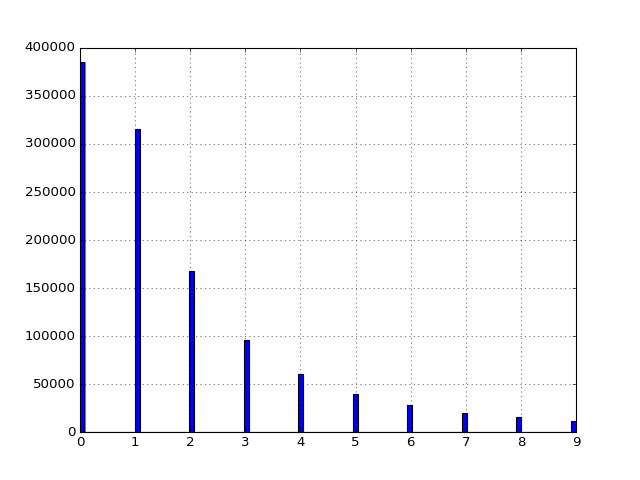

In [41]:
grps[grps.is_booking<10].is_booking.hist(bins=100)

In [56]:
grps20l = grps[grps.is_booking<=20][['user_id']]; grps20l.head()
grps20g = grps[grps.is_booking>20][['user_id']]; grps20g.head()

,user_id
934,934
983,983
1004,1004
1224,1224
1240,1240


In [ ]:
df=pd.DataFrame(rule4Arr5); df.head();
df.hist(bins=100); 
#len(df[[0]])

In [16]:
# Top clusters
rule5Arr5 = np.array([91,42,59,28])

In [60]:
# Validation on train(is_booking==1) datas
Validation = True
if Validation :        
    print(datetime.datetime.now(),'Validation')
    #readerTrain = pd.read_csv(fileValidation,chunksize=chunkSize);
    readerTrain = pd.read_csv(fileValidation,chunksize=1000000,usecols=ruleValidate+['user_id']);
    #readerTrain
    
    result = 0.0; resultl = []
    nEvent = 0;  
    ichunk = -1
    for chunk in readerTrain :
        ichunk += 1
        irow = -1;
        if (ichunk>3) : print(datetime.datetime.now(),'break'); break
        print(datetime.datetime.now(),'chunk :',ichunk,chunk.shape)
        
        # for round estimate (EFFECT IS NEGATIVE)
        #chunk['orig_destination_distance']=round(chunk['orig_destination_distance'],-1);
        
        chunk   = chunk.merge(grps20l,how='inner',on=['user_id'])
        
        chunk   = chunk.merge(rule1Test[0],how='left',on=rule1,suffixes=["_0","_1"]); #print(chunk.head())
        chunk   = chunk.merge(rule2Test[0],how='left',on=rule2,suffixes=["_1","_2"]); #print(chunk.head())
        chunk   = chunk.merge(rule3Test[0],how='left',on=rule3,suffixes=["_2","_3"]); #print(chunk.head())
        chunk   = chunk.merge(rule4Test[0],how='left',on=rule4,suffixes=["_3","_4"]); #print(chunk.head())
        
        rz  = np.array([-1]*nTop)
        
        rr  = chunk['nn_1'].copy(); rr[chunk.nn_1.isnull()] = 0; rr=rr.astype(int); 
        #print(rr.values[0:5],chunk.nn_1.isnull().tolist()[0:5])
        r1x = rule1Arr5[rr.values];
        r1x[chunk.nn_1.isnull().values] = rz;
        
        rr  = chunk['nn_2'].copy(); rr[chunk.nn_2.isnull()] = 0; rr=rr.astype(int); #print(rr.values[0:5])
        r2x = rule2Arr5[rr.values];
        r2x[chunk.nn_2.isnull().values] = rz;
        
        rr  = chunk['nn_3'].copy(); rr[chunk.nn_3.isnull()] = 0; rr=rr.astype(int); #print(rr.values[0:5])
        r3x = rule3Arr5[rr.values];
        r3x[chunk.nn_3.isnull().values] = rz;
        
        rr  = chunk['nn_4'].copy(); rr[chunk.nn_4.isnull()] = 0; rr=rr.astype(int); #print(rr.values[0:5])
        r4x = rule4Arr5[rr.values];
        r4x[chunk.nn_4.isnull().values] = rz;
        
        hcl = chunk['hotel_cluster']
        
        for irow in range(chunk.shape[0]):
            #if (irow>25000) : break;
            ra, rb  = [],[]
            nEvent += 1;
            xEvent  = 0;
            
            rr   = r1x[irow].tolist()+r2x[irow].tolist()+r3x[irow].tolist()+r4x[irow].tolist();
            res5 = [i for i in rr if i>-1][0:nTop]
                
            res = 0.0
            if hcl[irow] in res5 : res = 1/(res5.index(hcl[irow])+1)
            result += res
            resultl.append([res,xEvent])
            
            
            #if (nEvent%10000==0) : print(ichunk,irow,result,result/nEvent,hcl[irow],res5) #,ra,rb)
        
    print('----> result = ',result,result/nEvent,len(resultl))
    print(datetime.datetime.now(),'Done')
            
            



2016-06-04 07:34:15.479646 Validation
2016-06-04 07:34:17.467625 chunk : 0 (1000000, 11)
2016-06-04 07:35:00.961477 chunk : 1 (1000000, 11)
2016-06-04 07:35:44.302944 chunk : 2 (1000000, 11)
2016-06-04 07:36:25.129802 chunk : 3 (145036, 11)
----> result =  1001685.8500001676 0.3437481361601475 2914011
2016-06-04 07:36:32.623913 Done


In [27]:
import matplotlib
from matplotlib import pyplot as plt
%matplotlib notebook

In [ ]:
resultl
res=pd.DataFrame(resultl); res.columns=['result','who']; res['cumres']=res['result'].cumsum()
#res['who'].hist()
#res['result'].hist()
#res['cumres'].plot()
res[['cumres']].plot()
#res.shape


In [18]:
Submission = True
if Submission :        
    print(datetime.datetime.now(),'Build result')
    #readerTrain = pd.read_csv(fileValidation,chunksize=chunkSize);
    readerTrain = pd.read_csv(fileTest,chunksize=1000000,usecols=ruleTest);
    #readerTrain
    
    result = []
    id     = []
    nEvent = 0;  
    ichunk = -1
    
    r5x    = rule5Arr5
    
    for chunk in readerTrain :
        ichunk += 1
        irow = -1;
        #if (ichunk>3) : print(datetime.datetime.now(),'break'); break
        print(datetime.datetime.now(),'chunk :',ichunk,chunk.shape)
        
        # for round estimate (EFFECT IS NEGATIVE?)
        #chunk['orig_destination_distance']=round(chunk['orig_destination_distance'],-1);
        
        chunk   = chunk.merge(rule1Test[0],how='left',on=rule1,suffixes=["_0","_1"]); #print(chunk.head())
        chunk   = chunk.merge(rule2Test[0],how='left',on=rule2,suffixes=["_1","_2"]); #print(chunk.head())
        chunk   = chunk.merge(rule3Test[0],how='left',on=rule3,suffixes=["_2","_3"]); #print(chunk.head())
        chunk   = chunk.merge(rule4Test[0],how='left',on=rule4,suffixes=["_3","_4"]); #print(chunk.head())
        
        rz  = np.array([-1]*nTop)
        
        rr  = chunk['nn_1'].copy(); rr[chunk.nn_1.isnull()] = 0; rr=rr.astype(int); 
        #print(rr.values[0:5],chunk.nn_1.isnull().tolist()[0:5])
        r1x = rule1Arr5[rr.values];
        r1x[chunk.nn_1.isnull().values] = rz;
        
        rr  = chunk['nn_2'].copy(); rr[chunk.nn_2.isnull()] = 0; rr=rr.astype(int); #print(rr.values[0:5])
        r2x = rule2Arr5[rr.values];
        r2x[chunk.nn_2.isnull().values] = rz;
        
        rr  = chunk['nn_3'].copy(); rr[chunk.nn_3.isnull()] = 0; rr=rr.astype(int); #print(rr.values[0:5])
        r3x = rule3Arr5[rr.values];
        r3x[chunk.nn_3.isnull().values] = rz;
        
        rr  = chunk['nn_4'].copy(); rr[chunk.nn_4.isnull()] = 0; rr=rr.astype(int); #print(rr.values[0:5])
        r4x = rule4Arr5[rr.values];
        r4x[chunk.nn_4.isnull().values] = rz;
        
        id= id+chunk['id'].tolist()
        
        for irow in range(chunk.shape[0]):
            #if (irow>25000) : break;
            nEvent += 1;
            
            res5 =        [i for i in r1x[irow] if (i>-1)]
            res5 = res5 + [i for i in r2x[irow] if (i>-1) and (i not in res5)]
            res5 = res5 + [i for i in r3x[irow] if (i>-1) and (i not in res5)]
            res5 = res5 + [i for i in r4x[irow] if (i>-1) and (i not in res5)]
            res5 = res5 + [i for i in r5x       if (i>-1) and (i not in res5)]
            
            
                
            result.append(res5[0:nTop])
            
            #if (nEvent%10000==0) : print(ichunk,irow,result,result/nEvent,hcl[irow],res5) #,ra,rb)
        
    result = [x.__str__().replace(',','')[1:-1] for x in result];
    print('----> result = ',id[0:5],result[0:5],len(result))
    print(datetime.datetime.now(),'Done')
    
    
            

2016-06-04 05:45:04.482374 Build result
2016-06-04 05:45:08.838331 chunk : 0 (1000000, 8)
2016-06-04 05:47:22.874867 chunk : 1 (1000000, 8)
2016-06-04 05:49:37.774571 chunk : 2 (528243, 8)
----> result =  [0, 1, 2, 3, 4] ['5 37 55 22 11', '5 22 58 99 75', '91 96 77 48 59', '1 10 19 94 34', '50 51 91 2 59'] 2528243
2016-06-04 05:51:50.436253 Done


In [19]:
testResult = pd.DataFrame({'id':id,'hotel_cluster':result})
fileResult = os.path.join(dirResult,'df-Leak-'+datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')+'.csv'); fileResult

'..\\Result\\Leak\\df-Leak-2016-06-04-05-55-32.csv'

In [20]:
print(testResult.head(10),testResult.tail(10))

    hotel_cluster  id
0   5 37 55 22 11   0
1   5 22 58 99 75   1
2  91 96 77 48 59   2
3   1 10 19 94 34   3
4   50 51 91 2 59   4
5  91 42 95 48 39   5
6   95 21 98 91 2   6
7  41 59 21 37 28   7
8  88 10 19 94 34   8
9  55 32 34 10 50   9           hotel_cluster       id
2528233   21 59 95 4 19  2528233
2528234  59 87 81 65 52  2528234
2528235   82 85 36 7 61  2528235
2528236   93 85 7 48 15  2528236
2528237  71 80 84 92 90  2528237
2528238   34 26 73 0 84  2528238
2528239  57 62 46 36 82  2528239
2528240  54 10 19 94 34  2528240
2528241  50 47 43 15 32  2528241
2528242  12 36 57 81 62  2528242


In [21]:
print(testResult[['id','hotel_cluster']].head())
testResult[['hotel_cluster']].to_csv(fileResult,header=True,index_label="id")

   id   hotel_cluster
0   0   5 37 55 22 11
1   1   5 22 58 99 75
2   2  91 96 77 48 59
3   3   1 10 19 94 34
4   4   50 51 91 2 59


In [ ]:
rule1Test[0].head()

In [ ]:
xx=pd.DataFrame(rule1Arr5)
xx['r0'] =rule1Test[0]['user_location_city']
xx['r1'] =rule1Test[0]['orig_destination_distance']
xx['r1x']=round(rule1Test[0]['orig_destination_distance'])
xx.head()
len(xx.groupby(['r0','r1x'])); len(xx)

In [ ]:
xx.columns
xx[['r1',0]].query('r1>11000').plot(kind='scatter',x='r1',y=0)

In [ ]:
# Build round version ODD variable
rule1Test0 = rule1Test[0].copy();
rule1Test0['orig_destination_distance']=round(rule1Test0['orig_destination_distance'],-1);
yy = rule1Test0.groupby(['user_location_city','orig_destination_distance']).count().reset_index(); yy.nn=yy.index; 
print(yy.shape,'\n',yy.head())

xx = rule1Test0.merge(yy,how='left',on=rule1,suffixes=['_l','_r']); print(len(xx))

rule1Test0 = yy
rule1Test1 = np.zeros((len(yy),nClusters),dtype=int); 
for i in range(len(xx)) : rule1Test1[xx.nn_r[i]] += rule1Test[1][xx.nn_l[i]]
    
print(rule1Test[1][0])
print(rule1Test1[0])

In [ ]:
rule1ArrX = np.apply_along_axis(findTop,1,rule1Test1); print(rule1ArrX.shape,'\n',rule1ArrX[0:5]);

In [ ]:
# Change on round version
rule1Test[0]=rule1Test0
rule1Test[1]=rule1Test1
rule1Arr5=rule1ArrX


In [ ]:
 print(rule1Test0.shape,rule1Test1.shape,rule1ArrX.shape,'\n',rule1ArrX[0:5]);

In [ ]:
rule1ArrX[0:10]; pd.Series(rule1ArrX[:,4]).groupby(rule1ArrX[:,0]).count()

In [ ]:
pd.DataFrame(rule1ArrX).hist(bins=40)